<a target="_blank" href="https://colab.research.google.com/github/ZHAW-ZAV/TSO-FS25-students/blob/main/09_qpa/09_01_qpa1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import random
import sys
import os

#my comment test

IN_COLAB = "google.colab" in sys.modules

file_id_arrival_times = "13-R6GpZLw8WxeYPH5t7ZXdIYpw29iwtF"

if IN_COLAB:
    from google.colab import drive
    path_to_arrival_times = "/content/data/arrival_times.csv"
    os.makedirs(os.path.dirname(path_to_arrival_times), exist_ok=True)
    !gdown "https://drive.google.com/uc?id={file_id_arrival_times}" -O "{path_to_arrival_times}"

    # Download the TSO environment
    drive.mount("/content/drive")
    shared_file = "1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ"
    !gdown "https://drive.google.com/uc?id={shared_file}" -O tso-env.zip

    !unzip tso-env.zip -d /content | tqdm > /dev/null

    !source /content/tso-env/bin/activate

    sys.path.append("/content/tso-env/lib/python3.11/site-packages/")

else:
    import gdown

    url = f"https://drive.google.com/uc?id={file_id_arrival_times}"
    path_to_arrival_times = "data/arrival_times.csv"
    os.makedirs(os.path.dirname(path_to_arrival_times), exist_ok=True)
    gdown.download(url, path_to_arrival_times, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=13-R6GpZLw8WxeYPH5t7ZXdIYpw29iwtF
To: /content/data/arrival_times.csv
100% 162k/162k [00:00<00:00, 71.4MB/s]
Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ
From (redirected): https://drive.google.com/uc?id=1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ&confirm=t&uuid=d3b6c9a2-c237-4bc6-a0fd-51e96cd17a0c
To: /content/tso-env.zip
100% 362M/362M [00:04<00:00, 76.5MB/s]
27659it [00:15, 1775.41it/s]


In [3]:
from fitter import Fitter, get_common_distributions
import simpy

The code above loads the data, do not modify.

***

# TSO Semester Week 9: Quantitative Process Analysis

This exercise deals with the topic of quantitative process analysis using the example of a **security checkpoint** in a fictitious airport terminal. In PART A of this exercise, you will size this security checkpoint using the formulae described in the IATA Airport Development Reference Manual (i.e., you will determine the required number of servers and the space required for the queue using the formulae known from the INFRA-AD module). In the subsequent PARTS of this exercise, you will develop a Discrete Event Simulation (DES) model for the security check introduced in PART A. To this end, you will focus on the following topics:

* PART B: Creation of an activity diagram of the security control.
* PART C: Determination of the input parameters of the DES model
* PART D: Creation of a DES simulation model of the security control using *simpy*.
* PART E: Comparison of the results of the ADRM model (PART 1) with the results of the DES model (PART 4).

Note that PARTS B to E are based on the chapters *Introduction to Simulation Models* up to and including *DES Models with simPy* of the **TSO Quantitative Process Analysis Script**.


***
## PART A: Sizing Security Checkpoint using IATA ADRM Methods

Your task is to apply the models known from INFRA-AD for sizing and dimensioning **Processing Facilities** in airport passenger terminals (see video [*Sizing and Dimensioning of Processing Facilities*](https://zhaw.mediaspace.cast.switch.ch/media/t/0_7ene5y4g/7740?)) for a security checkpoint at an airport. Use the specifications below for Design Hour Load $DHL_{siko}$, average process time per passenger $PT$, and target level of service (maximum waiting time $MQT$, space guidelines $SP$).

Determine
1. the number of required servers $K$ (i.e. the number of security control lines),
2. the maximum number of passengers $Q_{max}$ queuing in front of the system, and
3. the building area $A_Q$ required for the queue.

In [4]:
# Parameters
DHL_siko = 1800     # Design Hour Load [PAX/h]
PT = 5.8            # Average Process Time per Passenger, [seconds]
MQT = 10            # Maximum Waiting Time (Economy Class), [minutes]
SP = 1.2            # Space quidelines, [m^2/PAX]

In [5]:
# PART A, Task 1
# Required number of security check lanes (i.e., capacity of facility)
K = np.ceil((DHL_siko * PT/60)/(60 + MQT))

print(f'Number of lanes: {K}')

Number of lanes: 3.0


In [6]:
# PART A, Tasks 2 & 3
# Calculation of maximum number of passengers in queue and required space for queue
Q_max = np.ceil((K * MQT)/(PT/60))

A_Q = Q_max * SP

print(f'Queue length: {Q_max} passengers; Queuing Area: {A_Q} m^2')

Queue length: 311.0 passengers; Queuing Area: 373.2 m^2


***
## PART B: DES Model Definition and Description

After having applied the methods already known from INFRA-AD for sizing flow facilities in airport passenger terminals in PART A, PARTS B to E of this exercise deal with **Discrete Event Simulation (DES) models**.


### Tasks Part B:
1. Draw an activity diagram of the security checkpoint (try to simplify as much as possible)
2. Determine the arrival and service processes of check security checkpoint
3. Identify and describe information and data required to properly simulate the security checkpoint / the arrival & service processes

#### PART B, Tasks 1 and 2: Activity Diagram
![Activity Diagram for Security Checkpoint](https://github.com/SimonsRepositories/zhaw-aviatik-tso/blob/main/figures/activity_diagram_siko.png?raw=1)

#### PART B, Task 3: Information and Data Required (Task 3)
The following information is required to simulate a security checkpoint by means of DES:
* Service process: Distribution and parametrization
* Arrival process: Distribution and parametrization
* Number of servers
* `SIM_TIME`: Total simulation time
* `NUM_RUNS`: Number of independent simulation runs
* Unit of time

***
## PART C: Input Data Collection and Parametrization of DES Simulation Model

For the DES model of the security check, we assume, based on an M/M/c queuing model, that the arrival process and the service process of the system can be modelled as follows:
* **Arrival Process**: The arrival process in an M/M/c system follows a Poisson process with a constant arrival rate $\lambda$ (lambda). The interarrival times (i.e., the time between two consecutive arrivals) are exponentially distributed with mean $\frac{1}{\lambda}$.
* **Service Process**: Each of the $c$ servers in an M/M/c system has an independent, exponentially distribued service time. The mean of the exponentially distributed random variable describing service time is equal to the service rate $\mu$ (mu).

![Security Checkpoint as M/M/c Queueing System](https://github.com/SimonsRepositories/zhaw-aviatik-tso/blob/main/figures/mmc_siko.png?raw=1)

### Tasks Part C:
1. Write function `generate_service_time()`, which allows the generation service times in the DES model. Use the expected / mean service time `PT` determined in PART A as input for function `generate_service_time()`.
2. File `arrival_times.csv` contains a series of observed **arrival times** of passengers entering the security checkpoint over the course of an entire day. Import this file and determine the observed **inter**arrival times of the passengers (i.e., the time between to consecutive arrials). Check graphically whether the observations are indepentent from each other or not?
3. Determine the probability density function best fitting the observed interarrival times. For this purpose, make use of the `fitter` library mentioned in the script.
4. Estimate the parameters of the best fitting density function.
5. Write function `generate_interarrival_time()` required to model the interarrival time in the DES model.
6. Determine the utiliztion ratio $\rho$ of the system, which is defined as $\rho = \frac{\lambda}{c \cdot \mu}$, where $\lambda$ is the arrival rate and $\mu$ is the service rate. Assume, that the number of servers $c$ is equal to `K` determined in PART A.

In [7]:
# PART C, Task 1: Define function `generate_service_time()`
mean_service_rate = 1/PT

# Function to generate service times
def generate_service_time(mean_service_rate):
    """Generate service time based on exponential distribution."""
    return random.expovariate(mean_service_rate)

In [8]:
# PART C, Task 2: Observed Interarrival Times

# Import File
# df_arrivals = pd.read_csv('data/arrival_times.csv', parse_dates=["timestamp"]) # FIXME  path_to_arrival_times
df_arrivals = pd.read_csv(path_to_arrival_times, parse_dates=["timestamp"])

# Compute interarrival times in seconds
df_arrivals["interarrival_time"] = df_arrivals["timestamp"].diff().dt.total_seconds()

# Remove the first row (NaN due to `diff()`)
df_arrivals = df_arrivals.dropna()

# Create X_i and X_{i+1}
X_i = df_arrivals["interarrival_time"][:-1].values  # All except last
X_next = df_arrivals["interarrival_time"][1:].values  # All except first

# Create DataFrame for Plotly
df_scatter = pd.DataFrame({"X_i": X_i, "X_next": X_next})

# Determine axis limits (equal for both)
axis_min = min(df_scatter["X_i"].min(), df_scatter["X_next"].min())
axis_max = max(df_scatter["X_i"].max(), df_scatter["X_next"].max())

# Create scatter plot to check for independence
fig = px.scatter(df_scatter, x="X_i", y="X_next", title="Scatter Plot of Consecutive Interarrival Times",
                 labels={"X_i": "Interarrival Time X_i (seconds)", "X_next": "Interarrival Time X_{i+1} (seconds)"},
                 opacity=0.6)

# Set equal axis limits and enforce equal aspect ratio
fig.update_layout(
    xaxis=dict(title="Interarrival Time X_i (seconds)", range=[axis_min, axis_max]),
    yaxis=dict(title="Interarrival Time X_{i+1} (seconds)", range=[axis_min, axis_max]),
    font=dict(size=14),
    autosize=False,
    width=700,  # Set figure width
    height=700, # Set figure height (square)
    margin=dict(l=50, r=50, t=50, b=50),
)

fig.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.008300,1025.862268,1039.050206,inf,0.013953,2.417061e-01
gamma,0.008638,1069.920320,1089.702228,inf,0.013224,2.989791e-01
exponpow,0.043712,1283.623575,1303.405482,inf,0.041284,1.966869e-08
lognorm,0.060403,925.927275,945.709182,inf,0.037857,3.694628e-07
chi2,0.104934,958.078851,977.860758,inf,0.093856,7.668623e-42


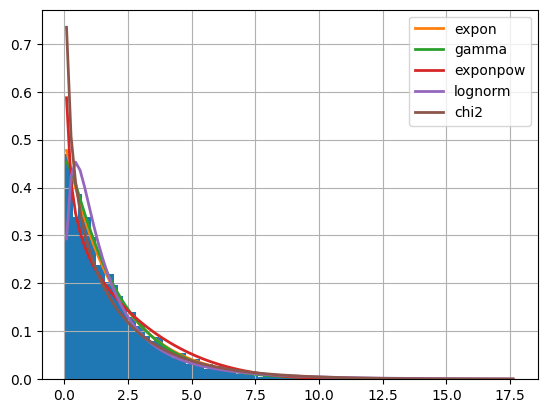

In [9]:
# PART C, Task 3: Fitting Probability Density Functions
# Define the set of distributions to fit
distributions_set = get_common_distributions()

# Fit the data to the specified distributions
f = Fitter(df_arrivals["interarrival_time"] , distributions=distributions_set)
f.fit()


# Display the fitting summary
f.summary()

In [10]:
# PART C, Task 4: Extracting Fitted Parameters

# The first param is the loc --> The distribution is not significantly shifted
# The second param is scale = 1/lambda --> we are only interested in

# Extract the fitted parameters of the exponential distribution
params = f.fitted_param['expon']

# The first param is the loc --> The distribution is not significantly shifted
loc = params[0]

# The second param is scale = 1/lambda --> we are interested in lambda
mean_arrival_rate = 1 / params[1]

print(f"Mean arrival rate: {mean_arrival_rate:.4f} passengers per unit time")

Mean arrival rate: 0.4989 passengers per unit time


In [11]:
# PART C, Task 5: Define function generate_interarrival_time()

# Function to generate interarrival times
def generate_interarrival_time(mean_arrival_rate):
    """Generate interarrival time based on exponential distribution."""
    return random.expovariate(mean_arrival_rate)

In [12]:
# PART C, Task 6: Utilization Ratio

rho = mean_arrival_rate/(K * mean_service_rate)

print(f'Utilization ratio of system: {rho:.4f}, service rate: {mean_service_rate:.4f} PAX per unit time, arrival rate: {mean_arrival_rate:.4f} PAX per unit time')

Utilization ratio of system: 0.9645, service rate: 0.1724 PAX per unit time, arrival rate: 0.4989 PAX per unit time


***
## PART D: DES Simulation Model
Below you will find a DES simulation model for an M/M/c queueing system. This simulation model requires functions `generate_interarrival_time()` and `generate_service_time()`, which you defined in PART C. `generate_interarrival_time()` is used to sample interarrival times of passengers, while `generate_service_time()` is used to sample service times.

The parameterisation of the DES model by means of global variables are to be found in the *Parametrization of Simulation Model* block below. Please note that in the current configuration of the parameters, the simulation model needs approximately one minute to perform the `NUM_RUNS = 500` independent simulation runs.

The simulation results for the delays experienced by the passengers (i.e. waiting times in the queue) can be found in the dataframe `df_delays`. Similarly, the resulting queue lengths can be found in the dataframe `df_queue_lengths`.

### Tasks Part D:
Execute the DES simulation model. Subsequently, use the simulation results in the dataframes `df_delays` and `df_queue_lengths` for the following tasks:
1. Create a plot showing the delays experienced by the passengers (i.e. delays vs. passenger index). To do this, plot (i) the average delay, the maximum observed delays, and the 10 and 90 percentiles.
2. Create a plot showing the observed queue lengths (i.e. queue length vs. passenger index). For this purpose, plot (i) the average queue length, the maximum observed queue length, and the 10 and 90 percentiles.
3. Determine for steady-state conditions (i) the average delay and the average queue length and (ii) the maximum delay & the maximum queue length.

In [13]:
# Parametrisation of Simulation Model
# Note: you have to define mean_arrival_rate and mean_service_rate first!!
C = K                                        # Number of Servers
ARRIVAL_RATE = mean_arrival_rate             # Lambda: Average number of arrivals per time unit
SERVICE_RATE = mean_service_rate             # Mu: Average number of services per server per time unit
SIM_TIME = 12 * 3600                              # Total simulation time [seconds]
NUM_RUNS = 400                                    # Number of independent simulation runs
CUSTOMER_INTERVAL = 5                             # Track every 5th customer for statistics


# Simulation function
def simulate_one_run(customer_interval):
    """Simulate a single M/M/c run and record delays & queue lengths for every `customer_interval` customer."""
    delays = {}
    queue_lengths = {}

    def customer(env, name, server, service_rate):
        """A customer process arriving and waiting for service."""
        arrival_time = env.now

        # Log queue length at arrival
        queue_length_at_arrival = len(server.queue)

        with server.request() as request:
            yield request  # Wait for the server
            wait_time = env.now - arrival_time  # Time spent in queue

            if name % customer_interval == 0:  # Record for every `customer_interval` customer
                delays[name] = wait_time
                queue_lengths[name] = queue_length_at_arrival

            service_time = generate_service_time(service_rate)
            yield env.timeout(service_time)  # Simulate service

    def arrival_process(env, server, arrival_rate, service_rate):
        """Process generating customers according to a Poisson arrival process."""
        customer_id = 0
        while True:
            interarrival_time = generate_interarrival_time(arrival_rate)
            yield env.timeout(interarrival_time)
            customer_id += 1
            env.process(customer(env, customer_id, server, service_rate))

    # Create the simulation environment
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=C)
    env.process(arrival_process(env, server, ARRIVAL_RATE, SERVICE_RATE))
    env.run(until=SIM_TIME)

    return delays, queue_lengths

# Run the simulation NUM_RUNS times and collect data
all_delays = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}
all_queue_lengths = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}

for run in range(NUM_RUNS):
    delays, queue_lengths = simulate_one_run(CUSTOMER_INTERVAL)

    for customer, delay in delays.items():
        if customer in all_delays:
            all_delays[customer].append(delay)

    for customer, queue_length in queue_lengths.items():
        if customer in all_queue_lengths:
            all_queue_lengths[customer].append(queue_length)

# Convert results to DataFrames for analysis
df_delays = pd.DataFrame.from_dict(all_delays, orient="index").T
df_queue_lengths = pd.DataFrame.from_dict(all_queue_lengths, orient="index").T


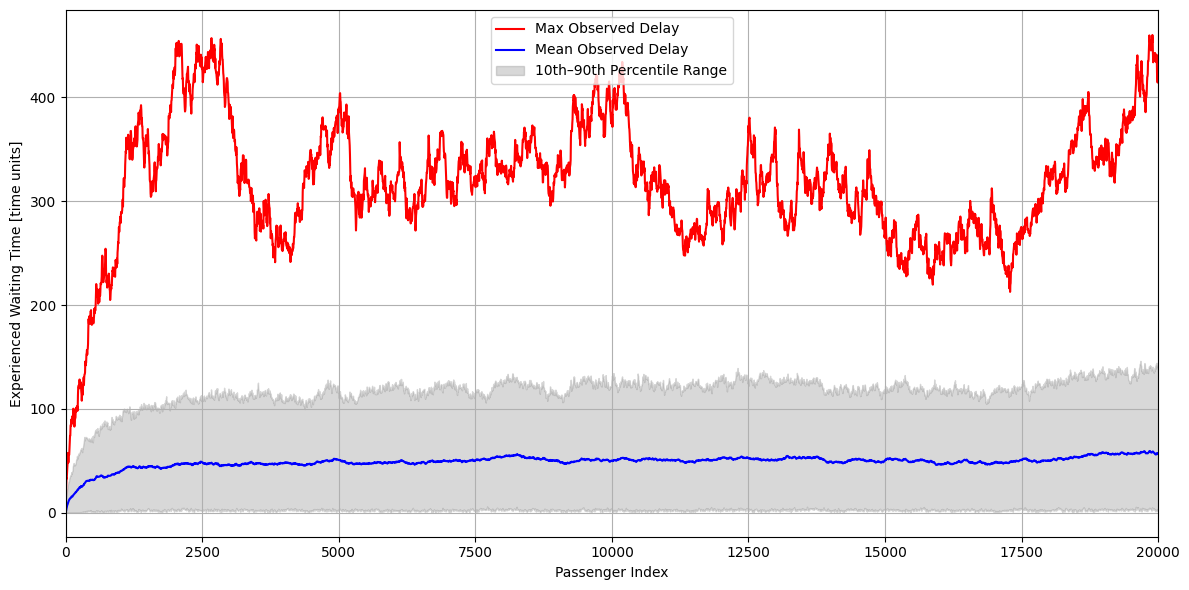

3455600


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Part D, Task 1: Plotting the Observed Delays

mean_delay = df_delays.mean(axis=0)           # blue line
max_delay  = df_delays.max(axis=0)            # red line
p10        = df_delays.quantile(0.10, axis=0) # lower grey band
p90        = df_delays.quantile(0.90, axis=0) # upper grey band

x = mean_delay.index.astype(int)  # passenger indices 0,1,2… (or +1 if you want 1…N)

plt.figure(figsize=(12,6))
plt.plot(x, max_delay,  color='red',   label='Max Observed Delay')
plt.plot(x, mean_delay, color='blue',  label='Mean Observed Delay')
plt.fill_between(x, p10, p90, color='gray', alpha=0.3, label='10th–90th Percentile Range')

plt.xlabel('Passenger Index')
plt.ylabel('Experienced Waiting Time [time units]')
plt.legend(loc='upper center')
plt.xlim(0, 20000)
plt.tight_layout()
plt.grid()
plt.show()

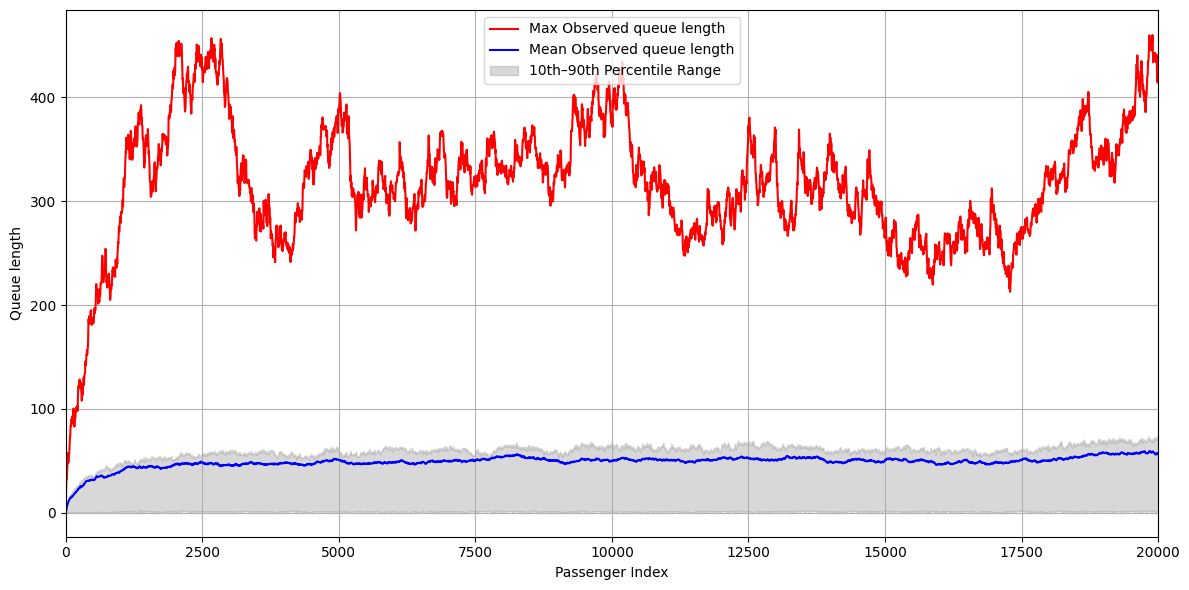

In [27]:
# Part D, Task 2: Plotting the Observed Queue Lengths
mean_queue_length = df_queue_lengths.mean(axis=0)           # blue line
max_queue_length  = df_queue_lengths.max(axis=0)            # red line
p10        = df_queue_lengths.quantile(0.10, axis=0) # lower grey band
p90        = df_queue_lengths.quantile(0.90, axis=0) # upper grey band

x = mean_queue_length.index.astype(int)  # passenger indices 0,1,2… (or +1 if you want 1…N)

plt.figure(figsize=(12,6))
plt.plot(x, max_delay,  color='red',   label='Max Observed queue length')
plt.plot(x, mean_delay, color='blue',  label='Mean Observed queue length')
plt.fill_between(x, p10, p90, color='gray', alpha=0.3, label='10th–90th Percentile Range')

plt.xlabel('Passenger Index')
plt.ylabel('Queue length')
plt.legend(loc='upper center')
plt.xlim(0, 20000)
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
# Part D, Task 3: Steady-State Analysis


***
## PART E: Comparison ADRM Model Results vs. DES Model Results

### Tasks:
1. Compare the results of the ADRM Model (PART A) with the results of the DES model in steady-state (PART D, Task 3).
2. Discuss for which applications the ADRM model is best used and for which a DES model should be used.

#### PART E, Task 1: Comparison on Models
Write your documentation here

#### PART E, Task 2: Fields of Application
Write your documentation here